In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

def pol2cart(r, tet, phi):
    x = r*np.sin(tet)*np.cos(phi)
    y = r*np.sin(tet)*np.sin(phi)
    z = r*np.cos(tet)
    return x,y,z

def cart2pol(vec):
    x = vec[0]
    y = vec[1]
    z = vec[2]
    r = np.linalg.norm(vec)
    tet = np.arccos(z/r)
    phi = np.arctan(y/x)
    return r, tet, phi

def r_ort(tet, phi):
    x = np.sin(tet)*np.cos(phi)
    y = np.sin(tet)*np.sin(phi)
    z = np.cos(tet)
    return np.array([x, y, z])

def tet_ort(tet, phi):
    x = np.cos(tet)*np.cos(phi)
    y = np.cos(tet)*np.sin(phi)
    z = -np.sin(tet)
    return np.array([x, y, z])

def phi_ort(tet, phi):
    x = -np.sin(phi)
    y = np.cos(phi)
    z = 0
    return np.array([x, y, z])


In [2]:
import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector

class Material:
    def __init__(self, Ms, gamma=5e8, alpha=0.018, Hkeff=6100.0, t=5e-9):
        self.Ms = Ms
        self.gamma = gamma
        self.alpha = alpha
        self.Hkeff = Hkeff
        self.t = t

        
class LayeredFilm:
    def __init__(self, layer1, layer2, J):
        self.l1 = layer1
        self.l2 = layer2
        self.J = J


class DemagnetizationEnergy:
    def __init__(self):
        S = CoordSys3D('S')
        
        Mz = symbols("Mz")
        self.E_eq = 2*sym.pi*(Mz**2)
        
    def Heff(self, M):
        return np.array([0., 0., -4.*np.pi*M[2]])

class StoenerWolfarthEnergy:
    def __init__(self):
        S = CoordSys3D('S')
        
        Ku = symbols("Ku")
        Mx, My, Mz = symbols('Mx My Mz')
        M = Mx*S.i + My*S.j + Mz*S.k
        
        sin_tet_sqr = (Mx**2 + My**2)/(Mx**2 + My**2 + Mz**2)
        
        self.E_eq = Ku*sin_tet_sqr
        
        Hx = -sym.diff(self.E_eq, Mx)
        Hy = -sym.diff(self.E_eq, My)
        Hz = -sym.diff(self.E_eq, Mz)
        
        lambda_var_set = (Ku, Mx, My, Mz)
        self.Heff_x = lambdify(lambda_var_set, Hx, 'numpy')
        self.Heff_y = lambdify(lambda_var_set, Hy, 'numpy')
        self.Heff_z = lambdify(lambda_var_set, Hz, 'numpy')
    
    def Heff(self, M, Ku):
        return np.array([
            self.Heff_x(Ku, M[0], M[1], M[2]),
            self.Heff_y(Ku, M[0], M[1], M[2]),
            self.Heff_z(Ku, M[0], M[1], M[2])
        ])

class IEC_Energy:
    def __init__(self):
        S = CoordSys3D('S')
        
        J, t = symbols("J t")
        
        Mx1, My1, Mz1 = symbols('Mx1 My1 Mz1')
        M1 = Mx1*S.i + My1*S.j + Mz1*S.k
        
        Mx2, My2, Mz2 = symbols('Mx2 My2 Mz2')
        M2 = Mx2*S.i + My2*S.j + Mz2*S.k
        
        self.E_eq = (J/t)*M1.dot(M2)/(M1.magnitude()*M2.magnitude())
        
        Hx1 = -sym.diff(self.E_eq, Mx1)
        Hy1 = -sym.diff(self.E_eq, My1)
        Hz1 = -sym.diff(self.E_eq, Mz1)
        
        Hx2 = -sym.diff(self.E_eq, Mx2)
        Hy2 = -sym.diff(self.E_eq, My2)
        Hz2 = -sym.diff(self.E_eq, Mz2)
        
        lambda_var_set = (
            J, t,
            Mx1, My1, Mz1,
            Mx2, My2, Mz2
        )
        
        self.Heff_x1 = lambdify(lambda_var_set, Hx1, 'numpy')
        self.Heff_y1 = lambdify(lambda_var_set, Hy1, 'numpy')
        self.Heff_z1 = lambdify(lambda_var_set, Hz1, 'numpy')
        
        self.Heff_x2 = lambdify(lambda_var_set, Hx2, 'numpy')
        self.Heff_y2 = lambdify(lambda_var_set, Hy2, 'numpy')
        self.Heff_z2 = lambdify(lambda_var_set, Hz2, 'numpy')
        
    def Heff1(self, M1, M2, J, t1):
        return [
            self.Heff_x1(J, t1, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2]),
            self.Heff_y1(J, t1, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2]),
            self.Heff_z1(J, t1, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2])
        ]
    
    def Heff2(self, M1, M2, J, t2):
        return [
            self.Heff_x2(J, t2, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2]),
            self.Heff_y2(J, t2, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2]),
            self.Heff_z2(J, t2, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2])
        ]
        

def IEC_Heff1(M1, M2, J, t1):
    K = J/(t1)
    first = M1.dot(M2)/((np.linalg.norm(M1)**3)*np.linalg.norm(M2))
    second = 1.0/(np.linalg.norm(M1)*np.linalg.norm(M2))
    return K*(M1*first-M2*second)

def IEC_Heff2(M1, M2, J, t2):
    return IEC_Heff1(M2, M1, J, t2)

In [3]:
import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector

class LLG_EQ:
    def __init__(self):
        S = CoordSys3D('S')
        
        x, y, z = symbols('x y z')
        dMdt = x*S.i + y*S.j + z*S.k
        
        Mx, My, Mz = symbols('Mx My Mz')
        M = Mx*S.i + My*S.j + Mz*S.k
        
        Hx, Hy, Hz = symbols('Hx Hy Hz')
        H = Hx*S.i + Hy*S.j + Hz*S.k
        
        g = sym.Symbol('g')
        a = sym.Symbol('a')
        Ms = sym.Symbol('Ms')
        
        vec_eq = -dMdt - g*M.cross(H)+(a/Ms)*(M.cross(dMdt))
        sol = sym.solve(vec_eq.to_matrix(S), dMdt.to_matrix(S))
        
        sol[x] = simplify(sol[x])
        sol[y] = simplify(sol[y])
        sol[z] = simplify(sol[z])
        
        self.sol_lamb = dict()
        lambda_var_set = (
            a, g, Ms, 
            Mx, My, Mz, 
            Hx, Hy, Hz)
        
        self.sol_lamb['x'] = lambdify(lambda_var_set, sol[x], 'numpy')
        self.sol_lamb['y'] = lambdify(lambda_var_set, sol[y], 'numpy')
        self.sol_lamb['z'] = lambdify(lambda_var_set, sol[z], 'numpy')
        
        symbs = [x, y, z]
        dsymbs = [Mx, My, Mz]
        self.jac_mat = []
        for i in range(3):
            jac_row = []
            for j in range(3):
                jac_row.append(
                    lambdify(
                        lambda_var_set, 
                        simplify(sol[symbs[i]].diff(dsymbs[j]))
                    )
                )
            self.jac_mat.append(jac_row)
    
    def right_hand(self, Heff, M, layer):
        x = self.sol_lamb['x'](
            layer.alpha, layer.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        y = self.sol_lamb['y'](
            layer.alpha, layer.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        z = self.sol_lamb['z'](
            layer.alpha, layer.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        return [x, y, z]
    
    #not allowed for multilayer no
    def jacobian(self, M, Heff, film):
        ret = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                ret[i][j] = self.jac_mat[i][j](
                    film.alpha, film.gamma, np.linalg.norm(M),
                    M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
                )
        return ret
             
    


In [10]:
equation = LLG_EQ()
demagnet_eq = DemagnetizationEnergy()
StWo_eq = StoenerWolfarthEnergy()
IEC_eq = IEC_Energy()

mu0 = 1.2566370621219e-6

uB_SI = 9.274009994e-24 #J/T
uB_CGS = 9.274009994e-21 #erg/G

hb_SI = 1.054571817e-34 # J*s
hb_CGS = 1.054571817e-27 #erg*s

g0_SI = uB_SI/hb_SI #1/(T*s)
g0_CGS = uB_CGS/hb_CGS #1/(G*s)

layer1 = Material(800., gamma=2.2*g0_CGS, alpha=0.005, t=12e-7, Hkeff=6e6)
layer2 = Material(800., gamma=2.2*g0_CGS, alpha=0.005, t=12e-7, Hkeff=6e6)
film_inst = LayeredFilm(layer1, layer2, 3.6) #J=-3.6 erg/cm^2


Hext = np.array(pol2cart(3e3, np.deg2rad(63.0), 0.0))
#Hext = np.array([0.0,0.0,0.0])
#Hext = np.array([160e-3/mu0,0.0,0.0])


def Heff_function(M1, M2, film):
    #Heff1 = Hext + IEC_Heff1(M1, M2, film.J, mu0, film.l1.t)
    #Heff2 = Hext + IEC_Heff2(M1, M2, film.J, mu0, film.l2.t)
    ###Heff1 = Hext + Demagnetization_Heff(M1) + IEC_Heff1(M1, M2, film.J, mu0, film.l1.t)  #--------------
    ###Heff2 = Hext + Demagnetization_Heff(M2) + IEC_Heff2(M1, M2, film.J, mu0, film.l2.t)  #--------------
    #Heff1 = Hext + StonerWohlfarth_Heff(M1, film.l1.Hkeff) + IEC_Heff1(M1, M2, film.J, mu0, film.l1.t)
    #Heff2 = Hext + StonerWohlfarth_Heff(M2, film.l2.Hkeff) + IEC_Heff2(M1, M2, film.J, mu0, film.l2.t)
    
    #Heff1 = Hext + demagnet_eq.Heff(M1) + StWo_eq.Heff(M1, film.l1.Hkeff) + IEC_Heff1(M1, M2, film.J, film.l1.t)
    #Heff2 = Hext + demagnet_eq.Heff(M2) + StWo_eq.Heff(M2, film.l2.Hkeff) + IEC_Heff2(M1, M2, film.J, film.l2.t)
    
    Heff1 = Hext + demagnet_eq.Heff(M1) + StWo_eq.Heff(M1, film.l1.Hkeff) + IEC_eq.Heff1(M1, M2, film.J, film.l1.t)
    Heff2 = Hext + demagnet_eq.Heff(M2) + StWo_eq.Heff(M2, film.l2.Hkeff) + IEC_eq.Heff2(M1, M2, film.J, film.l2.t)
    return Heff1, Heff2


def model(t,M1_M2):
    M1 = M1_M2[0:3]
    M2 = M1_M2[3:6]
    
    Heff1, Heff2 = Heff_function(M1, M2, film_inst)
    
    LLG1 = equation.right_hand(Heff1, M1, film_inst.l1)
    LLG2 = equation.right_hand(Heff2, M2, film_inst.l2)
    
    return np.append(LLG1, LLG2)

#fi_tmp_plane = np.arccos(mu0*(110e-3/mu0)*film_inst.l1.Ms*film_inst.l1.t/(2.0*film_inst.J))
#print(np.rad2deg(fi_tmp_plane))
fi_tmp_perp = np.pi/2.0 - np.arccos( 
    mu0*(110e-3/mu0)*film_inst.l1.Ms*film_inst.l1.t/
    (2.0*film_inst.J + mu0*film_inst.l1.t*(film_inst.l1.Ms**2)) 
)

M01 = pol2cart(film_inst.l1.Ms, np.deg2rad(0.0), np.deg2rad(0.0))
M02 = pol2cart(film_inst.l2.Ms, np.deg2rad(180.0), np.deg2rad(0.0))
M01_M02 = np.append(M01, M02)


time_span = [0.0, 4000.0e-12]
sol = solve_ivp(model, time_span, M01_M02,t_eval=np.linspace(time_span[0], time_span[1],100000),
                method = 'RK45', max_step=1e-13)


df = pd.DataFrame()
df['t'] = sol.t

df['x1'] = sol.y[0]
df['y1'] = sol.y[1]
df['z1'] = sol.y[2]
df['r1'] = np.sqrt(df['x1']**2+df['y1']**2+df['z1']**2)

df['x2'] = sol.y[3]
df['y2'] = sol.y[4]
df['z2'] = sol.y[5]
df['r2'] = np.sqrt(df['x2']**2+df['y2']**2+df['z2']**2)
df

,t,x1,y1,z1,r1,x2,y2,z2,r2
0,0.000000e+00,0.000000,0.000000,800.000000,800.0,9.797174e-14,0.000000,-800.000000,800.0
1,4.000040e-14,0.012314,-1.654776,799.998288,800.0,1.056952e-02,1.654798,-799.998288,800.0
2,8.000080e-14,0.032705,-3.309339,799.993154,800.0,2.572920e-02,3.309445,-799.993154,800.0
3,1.200012e-13,0.061171,-4.963608,799.984599,800.0,4.547838e-02,4.963885,-799.984598,800.0
4,1.600016e-13,0.097711,-6.617497,799.972624,800.0,6.981626e-02,6.618061,-799.972622,800.0
...,...,...,...,...,...,...,...,...,...
99995,3.999840e-09,132.049729,4.553766,789.013392,800.0,2.055356e+02,-4.865380,-773.130948,800.0
99996,3.999880e-09,132.029065,4.517805,789.017056,800.0,2.055222e+02,-4.768366,-773.135099,800.0
99997,3.999920e-09,132.008400,4.481648,789.020720,800.0,2.055093e+02,-4.671224,-773.139123,800.0
99998,3.999960e-09,131.987734,4.445296,789.024383,800.0,2.054968e+02,-4.573957,-773.143020,800.0


<IPython.core.display.Javascript object>


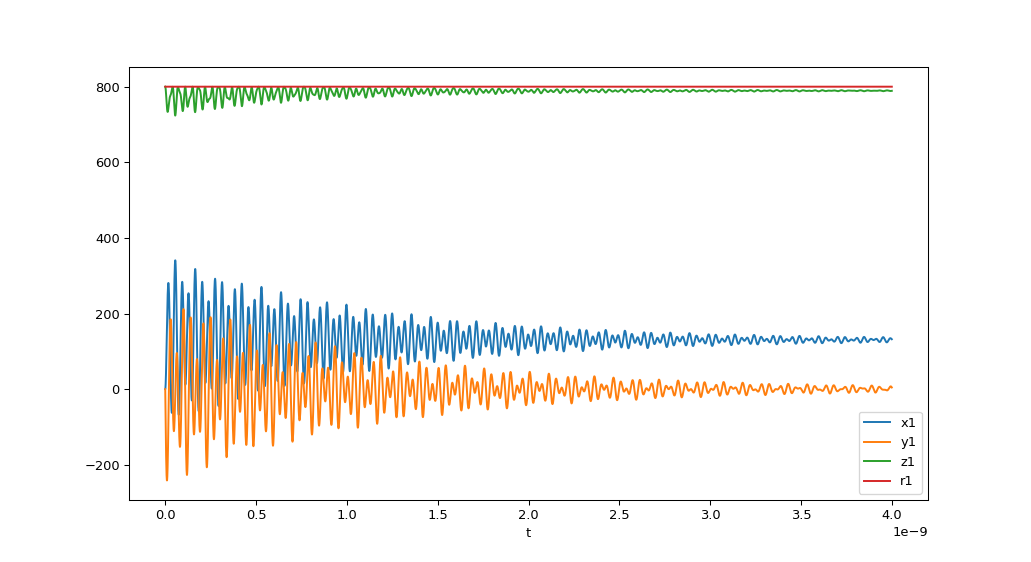

<AxesSubplot:xlabel='t'>

In [11]:
# %matplotlib inline
%matplotlib notebook
#%matplotlib qt

df.plot(x='t', y=['x1', 'y1', 'z1', 'r1'], figsize = (11, 6))

<IPython.core.display.Javascript object>


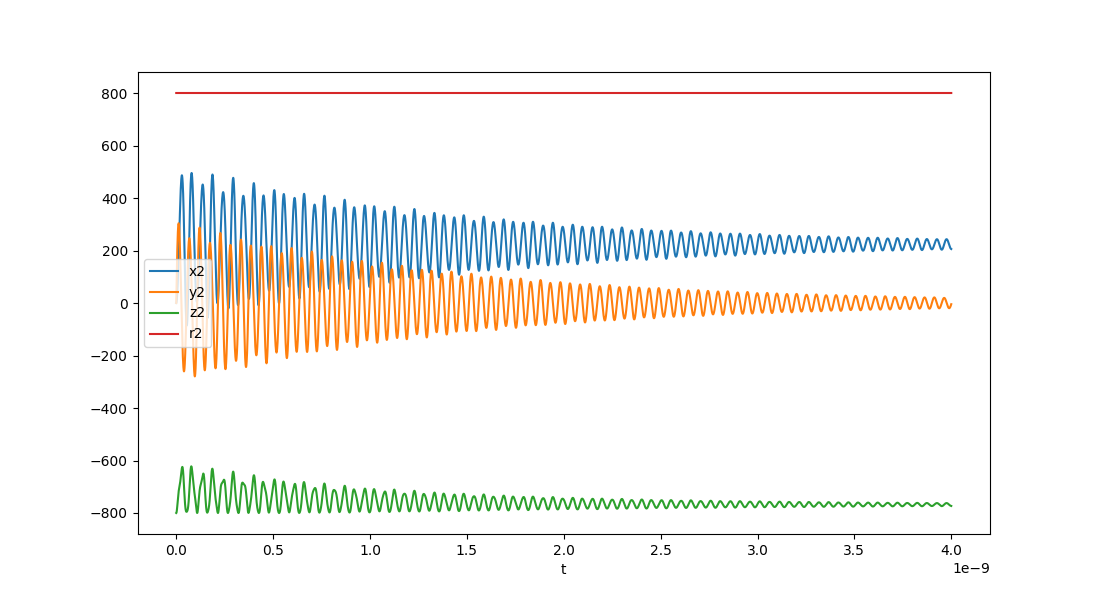

<AxesSubplot:xlabel='t'>

In [9]:
# %matplotlib inline
%matplotlib notebook
#%matplotlib qt

df.plot(x='t', y=['x2', 'y2', 'z2', 'r2'], figsize = (11, 6))

<IPython.core.display.Javascript object>


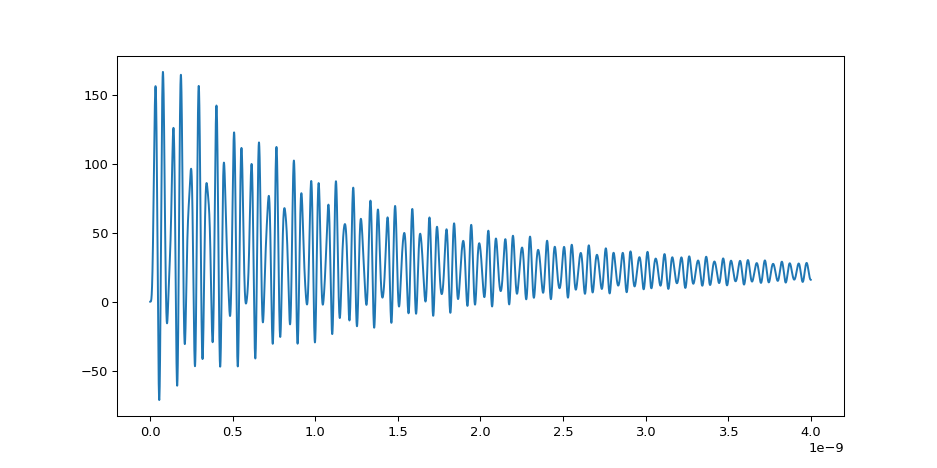

In [20]:
%matplotlib notebook
plt.subplots(figsize = (10, 5))
plt.plot(df.t, df.z1 + df.z2)

<IPython.core.display.Javascript object>


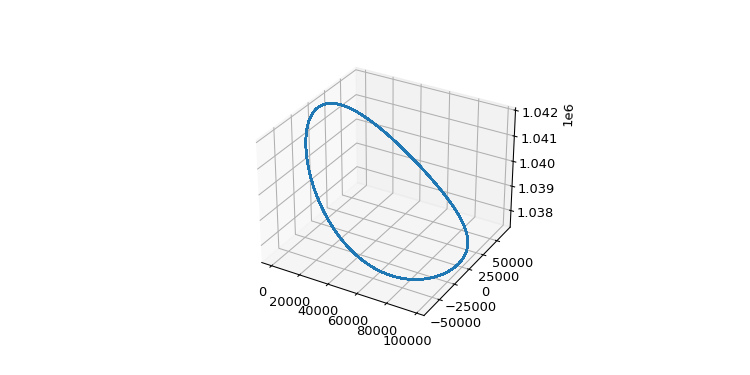

In [7]:
#%matplotlib inline
%matplotlib notebook
#%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])

27.749722500000004

<IPython.core.display.Javascript object>


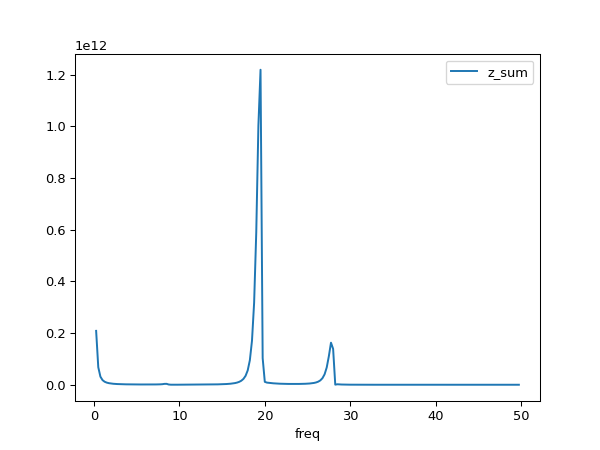

,freq,x1,y1,z1,x2,y2,z2,z_sum
0,0.249998,7.019668e+07,1.489195e+09,5.610645e+10,3.531982e+09,3.747411e+09,4.749283e+11,2.084680e+11
1,0.499995,4.149712e+07,1.532044e+09,2.466640e+10,1.526179e+09,3.909423e+09,1.724900e+11,6.780483e+10
2,0.749993,2.304980e+07,1.547158e+09,1.273284e+10,8.347379e+08,3.968175e+09,8.345786e+10,3.131772e+10
3,0.999990,1.385481e+07,1.554570e+09,7.577532e+09,5.454755e+08,3.999896e+09,4.852992e+10,1.787522e+10
4,1.249988,8.935974e+06,1.559506e+09,4.976540e+09,4.031036e+08,4.023957e+09,3.164477e+10,1.157748e+10
...,...,...,...,...,...,...,...,...
194,48.749513,3.324783e+08,2.831286e+08,1.056643e+08,3.279818e+08,1.842330e+08,1.215789e+08,5.619009e+05
195,48.999510,3.192846e+08,2.676989e+08,9.212699e+07,3.252657e+08,1.772247e+08,1.076560e+08,6.083103e+05
196,49.249508,3.072791e+08,2.538322e+08,8.109939e+07,3.222495e+08,1.707224e+08,9.622828e+07,6.502794e+05
197,49.499505,2.962459e+08,2.412513e+08,7.200915e+07,3.190598e+08,1.646998e+08,8.674441e+07,6.888988e+05


In [23]:
%matplotlib notebook
freq_df = pd.DataFrame(columns=['freq','x1','y1','z1','x2','y2','z2'])

freq_df['freq'] = np.fft.fftfreq(len(df.t), df.t[1]-df.t[0])[1:200] * 1e-9

column_names = ['x1','y1','z1','x2','y2','z2']
for name in column_names:
    freq_df[name] = np.abs(np.fft.fft(df[name]))[1:200]**2

freq_df["z_sum"] = np.abs(np.fft.fft(df.z1 + df.z2))[1:200]**2

display(freq_df['freq'][freq_df['z1'].argmax()])
#freq_df.plot(x='freq', y=['x1','y1', 'z1', 'x2', 'y2', 'z2'])
freq_df.plot(x='freq', y=['z_sum'])
freq_df

In [13]:
film_inst.l1.gamma * 1042e3 * 1e-9

230.4571840966595

# Legacy Code

<IPython.core.display.Javascript object>


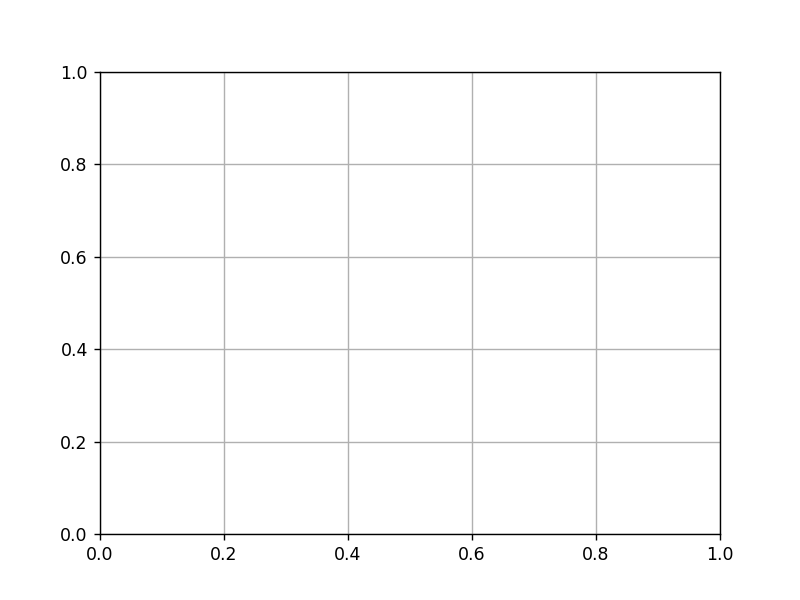

NameError: name 'heff' is not defined

In [101]:
%matplotlib notebook

#heff = [];
#for i in range(len(sol.t)):
#    heff.append(Heff(Hext, sol.y.T[i]))

#heff = np.array(heff).T

#ax.plot(heff[0], heff[1], heff[2])

plt.grid(True)
plt.plot(sol.t, heff[0])
plt.plot(sol.t, heff[1])
plt.plot(sol.t, heff[2])

In [12]:
import numpy as np
import sympy as sym
from sympy import symbols, simplify
from sympy.vector import CoordSys3D, matrix_to_vector, Del, gradient
S = CoordSys3D('S')

Mx, My, Mz = symbols("Mx My Mz")
M = Mx*S.i + My*S.j + Mz*S.k

Esh = -0.5*((M.dot(S.k))**2)
print(Esh)
print()
Heff = [-Esh.diff(Mx), -Esh.diff(My), -Esh.diff(Mz)]
for i in range(3):
    print(simplify(Heff[i]))

-0.5*Mz**2

0
0
1.0*Mz


In [66]:
import numpy as np
import sympy as sym
from sympy import symbols, simplify
from sympy.vector import CoordSys3D, matrix_to_vector, Del, gradient
S = CoordSys3D('S')

Mx1, My1, Mz1 = symbols("Mx1 My1 Mz1")
M1 = Mx1*S.i + My1*S.j + Mz1*S.k
Mx2, My2, Mz2 = symbols("Mx2 My2 Mz2")
M2 = Mx2*S.i + My2*S.j + Mz2*S.k
mu0_sym, J, tj = symbols("mu0 J tj")


Esh = (J/(mu0_sym*tj))*(M1.dot(M2)/(M1.magnitude()*M2.magnitude()))
print(simplify(Esh))
print()
Heff1 = [-Esh.diff(Mx1), -Esh.diff(My1), -Esh.diff(Mz1)]
for i in range(3):
    print(simplify(Heff1[i]))

M, tet1, tet2, A = symbols("M tet1 tet2 A") 
mx, my, mz = symbols("mx my mz")

simplify(Heff1[0].subs({
    Mx1: M*sym.cos(tet1),
    My1: M*sym.sin(tet1),
    Mz1: 0,
    
    Mx2: M*sym.cos(tet2),
    My2: M*sym.sin(tet2),
    Mz2: 0,
    
    J: A*mu0_sym*tj*M*M
    
}))
    

J*(Mx1*Mx2 + My1*My2 + Mz1*Mz2)/(mu0*tj*sqrt(Mx1**2 + My1**2 + Mz1**2)*sqrt(Mx2**2 + My2**2 + Mz2**2))

J*(Mx1*My1*My2 + Mx1*Mz1*Mz2 - Mx2*My1**2 - Mx2*Mz1**2)/(mu0*tj*(Mx1**2 + My1**2 + Mz1**2)**(3/2)*sqrt(Mx2**2 + My2**2 + Mz2**2))
J*(-Mx1**2*My2 + Mx1*Mx2*My1 + My1*Mz1*Mz2 - My2*Mz1**2)/(mu0*tj*(Mx1**2 + My1**2 + Mz1**2)**(3/2)*sqrt(Mx2**2 + My2**2 + Mz2**2))
J*(-Mx1**2*Mz2 + Mx1*Mx2*Mz1 - My1**2*Mz2 + My1*My2*Mz1)/(mu0*tj*(Mx1**2 + My1**2 + Mz1**2)**(3/2)*sqrt(Mx2**2 + My2**2 + Mz2**2))


A*M*(-cos(tet2) + cos(2*tet1 - tet2))/2

In [63]:
expr = Mx+My
expr.subs({Mx: Mz, My:Mz})

2*Mz